# Домашняя работа №3

**Срок сдачи:** 3 декабря 2017, 23:59 <br\>
Штраф за опоздание: -1 балл за каждый день

Файл с дз надо загрузить по [ссылке](https://www.dropbox.com/request/ygtyw9rRFTovCvtJu44k)<br/>
Постарайтесь назвать файл по следующему формату:** [ИАД-*{Номер}*] *{Фамилия}* *{Имя}* ДЗ*{Номер}* **<br/>

Сопровождайте ваш код изображеними, комментариями и выводами. <br/>
Иммейте ввиду, что на некоторые задачи нет единственного верного и полного ответа. Чем больше информации вы сможете извлечь, аргументированных выводов сформулировать, тем лучше.

Используйте данный Ipython Notebook при оформлении домашнего задания.

# Преамбула

Автоэнкодеры - это полносвязные сети, задачей которых является на выходе сети восстановить объекты, поданные на вход. Такие сети состоят из двух частей - енкодера и декодера. В каждом следующем слое энкодера становится всё меньше и меньше нейронов, в результате чего происходит "сжатие" исходной информации. В самом сжатом виде информация находится на последнем слое энкодера который называется bottleneck(с англ. бутылочное горлышко). Далее информация из bottleneck'a подаётся на вход декодеру, у которого наоборот с каждый следующим слоем количество нейронов становится больше и больше. Размерности выходов и входов такой нейронной сети совпадают. 

<img src="https://cdn-images-1.medium.com/max/1600/1*HIBRgSV2ePFtCSOF_lgPCQ.png">

Активации нейронов с самого узкого слоя можно использовать как довольно качественные признаки для передачи в другие модели машинного обучения.

Целью данного домашнего задания является реализация нескольких вариантов автокодировщиков, проведение экспериментов с целью определения структур, которые выучивают нейроны. 

In [1]:
import numpy

import keras

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Загрузка и предобработка данных(2.5 балла).

Загрузите *images.npy*. Данный файл содержит набор фото. 

In [2]:
import pickle as pkl
import numpy as np

images = np.load(open('/Users/maxim_anisimov/Desktop/ML_data/HW_3/images.npy', 'br'))

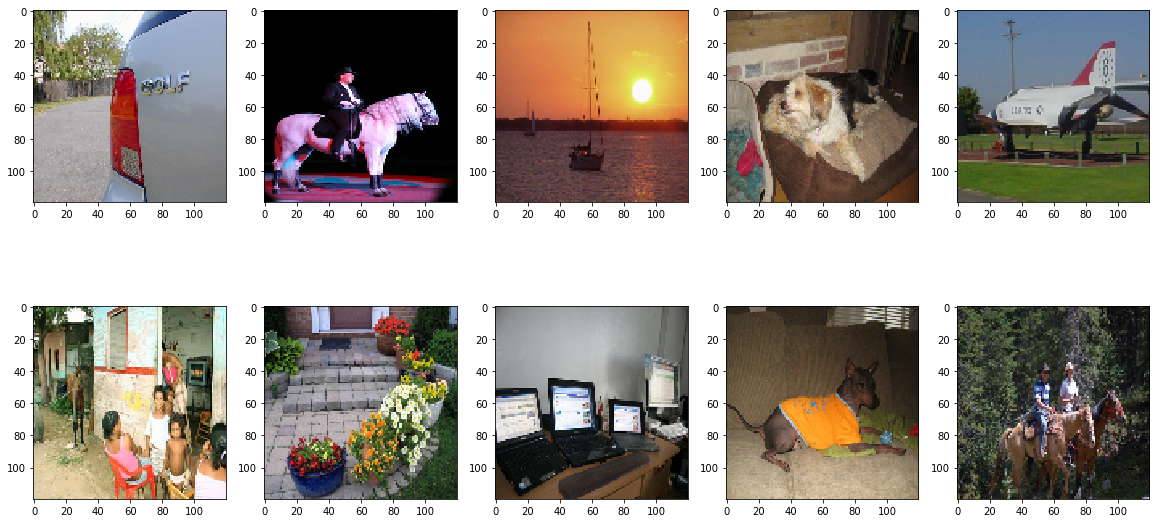

In [3]:
plt.figure(figsize=(20, 10)) 

for i in range(10): 
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])

## Генерация датасета(2 балла)

Напишите функцию, которая принимает на вход исходный набор фотографий из возращает нужное количество "сэмплов" - случайных квадратных подкартинок нужного размера. Визуализируйте несколько сэмплов.

In [4]:
images.shape # посмотрим на размерность данных с картинками
# имеем 7000 картинок размеров 120х120 с RGB-каналом

(7000, 120, 120, 3)

In [5]:
import random # загрузим для рандомного выбора среза картинки

In [6]:
def get_samples(full_images, num_samples=10000, sample_size=16, rand_seed=123):
    samples = np.empty([num_samples, sample_size, sample_size, 3]) # создаем пустую матрицу нужной размерности
    for i in range(num_samples): # проходимся нужно число раз
        m = random.randint(0 , len(full_images) - 1) # выбираем картинку
        n = random.randint(0 , full_images.shape[1] - sample_size) # выбираем начальный пиксель для среза
        sample = full_images[m][n:n + sample_size, n:n + sample_size] # делаем срез
        samples[i] = sample # добавляем набор срезов
    return samples

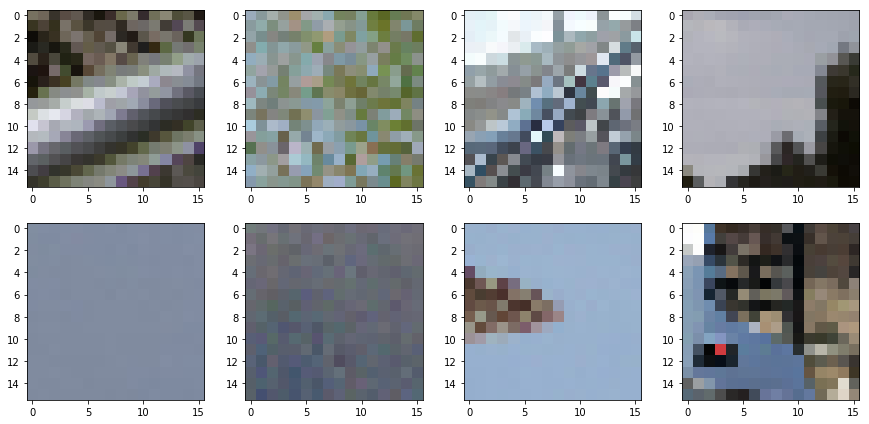

In [7]:
samples_first = get_samples(images, num_samples=8,sample_size=16, rand_seed=123)

plt.figure(figsize=(15, 15)) 
for i in range(8): # рисуем 8 картинок
    plt.subplot(4, 4, i + 1)
    plt.imshow(samples_first[i])

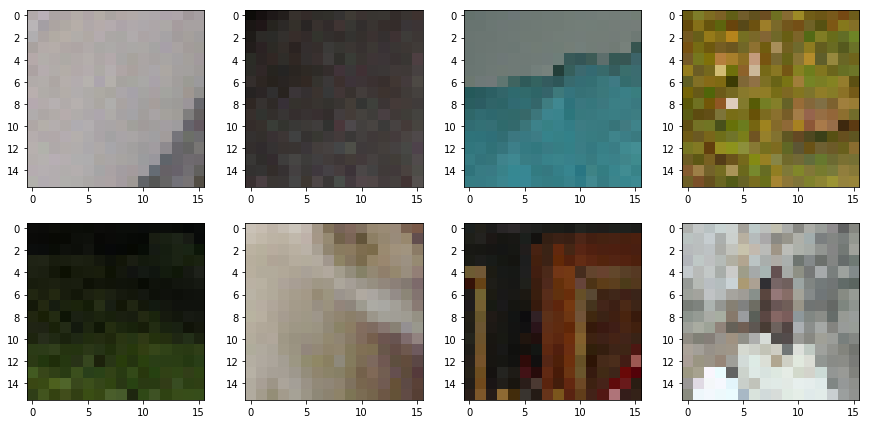

In [8]:
samples_second = get_samples(images, num_samples=8,sample_size=16, rand_seed=123)

plt.figure(figsize=(15, 15))
for i in range(8):
    plt.subplot(4, 4, i + 1)
    plt.imshow(samples_second[i])

## Нормировка картинок и вытягивание их в один вектор(0.5 балл)

Переведите интенсивности каждого канала (R, G, B) в отрезок $[0.1, 0.9]$. Значения отбрасывать не надо, просто отшкалируйте каналы.

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scale = MinMaxScaler(feature_range=(0.1, 0.9)) # задаем необходимую шкалу

In [31]:
scl_images = np.empty(images.shape) # создаем пустую матрицу

In [32]:
for i in range(3):
    for j in range(7000):
        scl_images[j,:,:,i] = scale.fit_transform(images[j,:,:,i]) # заменяем старые пиксели преобразованными

Преобразуйте каждый семпл-матрицу в вектор.

То есть из исходного набора сэмплов размера [num_samples, sample_size, sample_size, 3] должен получиться набор размера [num_samples, sample_size x sample_size x 3].

In [33]:
reshaped_images = scl_images.reshape(7000, 120*120*3) # преобразовываем в вектор

# Реализация и обучение автокодировщика(4 балла)

### Построение автокодировщика(1.5 балла)

Напишите функцию, которая принимает параметры автокодировщика(размер входа и выхода, количества нейронов в каждом слое энкодера, количество нейронов в каждом слое декодера). Внутри автокодировщика использовать нелинейности-RELU. Но для выходов автоэнкодера использовать сигмоиду.

Выход функции - Keras модель, скомпилированная чтобы минимизировать MSE на трэйне. Оптимизатор - на ваш выбор.

In [34]:
from keras.layers import Input, Dense, Flatten, Reshape
from keras.models import Model

In [35]:
def create_autoencoder_model(object_size=768, encoder_layer_shapes=[256, 144, 64], decoder_layer_shapes=[200, 400]):
    input_image = Input(shape=(object_size,)) # берем картинку
    layer1 = Dense(encoder_layer_shapes[0], activation='relu')(input_image) # прогоняем через 1 слой сети
    layer2 = Dense(encoder_layer_shapes[1], activation='relu')(layer1) # прогоняем через второй
    encoded = Dense(encoder_layer_shapes[2], activation='relu')(layer2) # bottleneck
    
    layer1 = Dense(decoder_layer_shapes[0], activation='sigmoid')(encoded) # первый слой декодера
    decoded = Dense(decoder_layer_shapes[1], activation='sigmoid')(layer2) # второй слой
    
    model = Model(input_image, decoded)
    
    return model

In [36]:
autoencoder = create_autoencoder_model()
autoencoder.compile(optimizer='adam', loss='mse')

Разделите выборку из сэмплов на тренировочную выборку и валидационную отношении 90%-10%.

In [37]:
data = get_samples(scl_images, num_samples=10000, sample_size=16, rand_seed=123).reshape(10000, 16*16*3)

In [38]:
data.shape

(10000, 768)

In [39]:
X_test, X_train = data[:9000], data[9000:10000]

Обучите модель со стандартными параметрами.

In [40]:
autoencoder.fit(X_train, X_train, epochs=100, batch_size=256, shuffle=True, validation_data=(X_test, X_test))

ValueError: Error when checking target: expected dense_11 to have shape (None, 400) but got array with shape (1000, 768)

### Визуализация паттернов, которые находят нейроны(1.5 балла)

Возьмите несколько объектов из валидационной выборки и прогоните через автоэнкодер. Оцените визуально результат восстановления объектов.

In [41]:
test_data = X_test[10:20]

In [42]:
img_hat = autoencoder.predict(test_data)

ValueError: cannot reshape array of size 400 into shape (16,16,3)

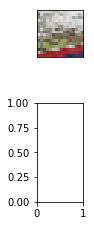

In [43]:
n=20
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data[i].reshape(16, 16, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(img_hat[i].reshape(16, 16, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Для каждого слоя и для каждого нейрона на этом слое найдите объект из тренировочной выборки, на котором этот нейрон выдаёт наибольшую активацию. Если нейрон ни на одном объекте не активировался, пропустите изображение для него. Что можете сказать про сложность шаблонов на объектах для каждого слоя?

### Исследование зависимости качества восстановления от параметров автоэнкодера (1 балл)


Обучите несколько автоэнкодеров с различным количеством слоёв, разными размерами bottleneck'a и сравните, насколько быстро модели обучаются и финальный лосс на валидационной выборке. Какие выводы вы можете сделать?

# Классификация MNIST и CIFAR (3,5 балла)

### MNIST (2 балла)

Загрузите датасет MNIST и провизуализируйте несколько цифр.

In [11]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11419648/11490434 [============================>.] - ETA: 0s

In [12]:
mnist.head()

AttributeError: module 'keras.datasets.mnist' has no attribute 'head'

Сожмите данные автокодировщиком, у которого только один скрытый слой(по сути только bottleneck) с 30 нейронами.

Возьмите несколько моделей из sklearn (KNN,SVM, RandomForest, GradientBoosting/XGBClassifier) и обучите модель со стандартными параметрами на выходах энкодера. Какие у вас получились результаты(точность) на тесте?

### CIFAR10(2 балла)

Загрузите CIFAR10 и обучите автоэнкодер на случайных сэмплах размера 8x8 из этого датасета. Архитектура автоэнкодера как в прошлом пункте - только один внутренний слой из 30 нейронов.

In [ ]:
from keras.datasets import cifar10

Теперь разделите каждую картинку из датасета на 16 сэмплjd размера 8x8, закодируйте их через энкодер и склейте 16 выходов энкодера в один вектор. Каждый объект в итоге должен кодироваться 16 * 30 = 380 признаками.

Теперь обучите SVM на преобразованных объектах и выведите точность.